## Sequence to Sequence 구현

**언어 모델(Language Model)**이란,   
주어진 단어들을 보고 다음 단어를 맞추는 모델 
-> 단어의 시퀀스를 보고 다음 단어에 확률을 할당하는 모델


**Sequence to Sequence Learning with Neural Networks**  
https://proceedings.neurips.cc/paper_files/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf  


### LSTM Encoder
- 데이터를 직접 다루기 보다 차원 수를 확인하는 실습
- 입력으로 Embedding된 단어만 전달

In [1]:
import tensorflow as tf

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(enc_units) # return_sequences 매개변수를 기본값 False로 전달

    def call(self, x):
        print("입력 Shape:", x.shape)

        x = self.embedding(x)
        print("Embedding Layer를 거친 Shape:", x.shape)

        output = self.lstm(x)
        print("LSTM Layer의 Output Shape:", output.shape)

        return output

- Embedding 레이어를 단어 사이즈와 Embedding 차원에 대해 선언을 한 후, 논문에서 소개한 대로 tf.keras.layers.LSTM(enc_units)으로 LSTM을 정의
- Tensorflow의 LSTM 모듈의 기본 반환값은 최종 state 값이므로, 우리가 정의해 준 Encoder 클래스의 반환 값이 곧 컨텍스트 벡터(Context Vector) 가 됨

In [2]:
vocab_size = 30000
emb_size = 256
lstm_size = 512
batch_size = 1
sample_seq_len = 3

print("Vocab Size: {0}".format(vocab_size))
print("Embedidng Size: {0}".format(emb_size))
print("LSTM Size: {0}".format(lstm_size))
print("Batch Size: {0}".format(batch_size))
print("Sample Sequence Length: {0}\n".format(sample_seq_len))

Vocab Size: 30000
Embedidng Size: 256
LSTM Size: 512
Batch Size: 1
Sample Sequence Length: 3



In [3]:
encoder = Encoder(vocab_size, emb_size, lstm_size)
sample_input = tf.zeros((batch_size, sample_seq_len))

sample_output = encoder(sample_input)    # 컨텍스트 벡터로 사용할 인코더 LSTM의 최종 State값

입력 Shape: (1, 3)
Embedding Layer를 거친 Shape: (1, 3, 256)
LSTM Layer의 Output Shape: (1, 512)


### LSTM Decoder

In [4]:
# Encoder 구현에 사용된 변수들을 이어 사용함에 유의!

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(dec_units,
                                         return_sequences=True) # return_sequences 매개변수를 True로 설정
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.softmax = tf.keras.layers.Softmax(axis=-1)

    def call(self, x, context_v):  # 디코더의 입력 x와 인코더의 컨텍스트 벡터를 인자로 받는다. 
        print("입력 Shape:", x.shape)

        x = self.embedding(x)
        print("Embedding Layer를 거친 Shape:", x.shape)

        context_v = tf.repeat(tf.expand_dims(context_v, axis=1),
                              repeats=x.shape[1], axis=1)
        x = tf.concat([x, context_v], axis=-1)  # 컨텍스트 벡터를 concat 해준다
        print("Context Vector가 더해진 Shape:", x.shape)

        x = self.lstm(x)
        print("LSTM Layer의 Output Shape:", x.shape)

        output = self.fc(x)
        print("Decoder 최종 Output Shape:", output.shape)

        return self.softmax(output)

- Encoder와 구조적으로 유사하지만 결과물을 생성해야 하므로 Fully Connected 레이어가 추가되었음
- 출력값을 확률 값으로 변환해주는 Softmax함수도 추가되었음
- Decoder가 매 스텝 생성하는 출력은 우리가 원하는 번역 결과에 해당하므로 LSTM 레이어의 return_sequences 변수를 True로 설정하여 State 값이 아닌 Sequence 값을 출력으로 받습니다.

In [5]:
print("Vocab Size: {0}".format(vocab_size))
print("Embedidng Size: {0}".format(emb_size))
print("LSTM Size: {0}".format(lstm_size))
print("Batch Size: {0}".format(batch_size))
print("Sample Sequence Length: {0}\n".format(sample_seq_len))

Vocab Size: 30000
Embedidng Size: 256
LSTM Size: 512
Batch Size: 1
Sample Sequence Length: 3



In [6]:
decoder = Decoder(vocab_size, emb_size, lstm_size)
sample_input = tf.zeros((batch_size, sample_seq_len))

dec_output = decoder(sample_input, sample_output)  # Decoder.call(x, context_v) 을 호출

입력 Shape: (1, 3)
Embedding Layer를 거친 Shape: (1, 3, 256)
Context Vector가 더해진 Shape: (1, 3, 768)
LSTM Layer의 Output Shape: (1, 3, 512)
Decoder 최종 Output Shape: (1, 3, 30000)


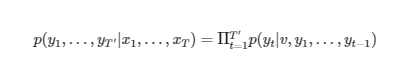
- Encoder가 생성한 컨텍스트 벡터 v 를 Embedding 레이어를 거친 y 값에 Concatnate하여 위 수식을 만족시킴
- 즉, Seq2seq을 완성함

## Attention

- Seq2Seq의 한계점을 극복하고 발전시키려는 시도의 대표적인 방법이 Attention 메커니즘

### Bahdanau Attention
- Seq2Seq의 컨텍스트 벡터가 고정된 길이로 정보를 압축하는 것이 손실을 야기한다
- Encoder의 최종 State 값만을 사용하는 기존의 방식이 아닌, 매 스텝의 Hidden State를 활용해 컨텍스트 벡터를 구축하는 Attention 메커니즘을 제안

In [7]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W_decoder = tf.keras.layers.Dense(units)
        self.W_encoder = tf.keras.layers.Dense(units)
        self.W_combine = tf.keras.layers.Dense(1)

    def call(self, H_encoder, H_decoder):
        print("[ H_encoder ] Shape:", H_encoder.shape)

        H_encoder = self.W_encoder(H_encoder)
        print("[ W_encoder X H_encoder ] Shape:", H_encoder.shape)

        print("\n[ H_decoder ] Shape:", H_decoder.shape)
        H_decoder = tf.expand_dims(H_decoder, 1)
        H_decoder = self.W_decoder(H_decoder)

        print("[ W_decoder X H_decoder ] Shape:", H_decoder.shape)

        score = self.W_combine(tf.nn.tanh(H_decoder + H_encoder))
        print("[ Score_alignment ] Shape:", score.shape)

        attention_weights = tf.nn.softmax(score, axis=1)
        print("\n최종 Weight:\n", attention_weights.numpy())

        context_vector = attention_weights * H_decoder
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

W_size = 100

print("Hidden State를 {0}차원으로 Mapping\n".format(W_size))

attention = BahdanauAttention(W_size)

enc_state = tf.random.uniform((1, 10, 512))
dec_state = tf.random.uniform((1, 512))

_ = attention(enc_state, dec_state)

Hidden State를 100차원으로 Mapping

[ H_encoder ] Shape: (1, 10, 512)
[ W_encoder X H_encoder ] Shape: (1, 10, 100)

[ H_decoder ] Shape: (1, 512)
[ W_decoder X H_decoder ] Shape: (1, 1, 100)
[ Score_alignment ] Shape: (1, 10, 1)

최종 Weight:
 [[[0.09159105]
  [0.08008362]
  [0.04653067]
  [0.07061282]
  [0.09586233]
  [0.11116278]
  [0.1509214 ]
  [0.08709237]
  [0.14130373]
  [0.12483916]]]


- Encoder의 모든 스텝에 대한 Hidden State를 100차원의 벡터 공간으로 매핑 (1, 10, 100) 하고, Decoder의 현재 스텝에 대한 Hidden State 역시 100차원의 벡터 공간으로 매핑 (1, 1, 100)해 두 State의 합으로 정의된 Score (1, 10, 1) 를 구하는 모습
- Softmax를 거쳐 나온 값은 0-1 사이의 값으로 각 단어가 차지하는 비중을 의미
- 유사한 단어에 높은 비중을 할당하게 됨
- 시각화하면 아래와 같은 그림을 볼 수 있음

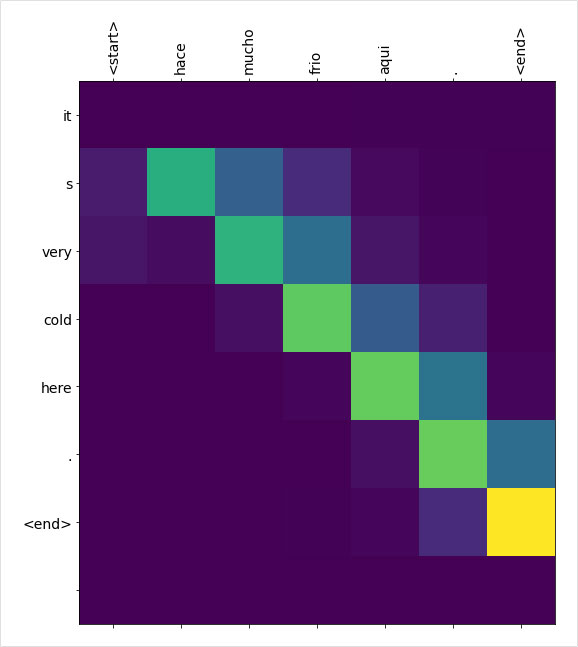
[Attention Map]
https://www.tensorflow.org/tutorials/text/nmt_with_attention?hl=ko

### Luong Attention
- Bahdanau의 방식을 약간 발전시킨 형태 
- Hidden State Vector를 구하는 방식이 간소화
- Local attention을 사용
- Dot, General, Concat, Location 4가지 Score 함수를 제시
- 이 중 General이 가장 합리적인 성능을 보임
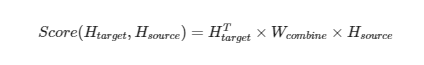

In [8]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.W_combine = tf.keras.layers.Dense(units)

    def call(self, H_encoder, H_decoder):
        print("[ H_encoder ] Shape:", H_encoder.shape)

        WH = self.W_combine(H_encoder)
        print("[ W_encoder X H_encoder ] Shape:", WH.shape)

        H_decoder = tf.expand_dims(H_decoder, 1)
        alignment = tf.matmul(WH, tf.transpose(H_decoder, [0, 2, 1]))
        print("[ Score_alignment ] Shape:", alignment.shape)

        attention_weights = tf.nn.softmax(alignment, axis=1)
        print("\n최종 Weight:\n", attention_weights.numpy())

        attention_weights = tf.squeeze(attention_weights, axis=-1)
        context_vector = tf.matmul(attention_weights, H_encoder)

        return context_vector, attention_weights

emb_dim = 512

attention = LuongAttention(emb_dim)

enc_state = tf.random.uniform((1, 10, emb_dim))
dec_state = tf.random.uniform((1, emb_dim))

_ = attention(enc_state, dec_state)

[ H_encoder ] Shape: (1, 10, 512)
[ W_encoder X H_encoder ] Shape: (1, 10, 512)
[ Score_alignment ] Shape: (1, 10, 1)

최종 Weight:
 [[[6.3338660e-04]
  [3.6904425e-05]
  [9.7413242e-01]
  [1.8494813e-03]
  [1.3767654e-02]
  [7.2732004e-03]
  [1.8730140e-06]
  [2.2901129e-03]
  [3.7112920e-06]
  [1.1118009e-05]]]


- Bahdanau의 Score 함수와는 다르게 하나의 Weight만을 사용하는 것이 특징
- 어떤 벡터 공간에 매핑해주는 과정이 없기 때문에 Weight의 크기는 단어 Embedding 크기와 동일해야 연산이 가능

- Attention은 번역 모델에서 입력 문장의 단어와 출력 문장의 단어 사이의 매핑 관계를 찾아내는 메커니즘으로 이를 통해 입력 문장의 모든 단어를 고려하면서 출력 문장의 각 단어를 예측
- 문장이 길어질수록 Attention계산에 필요한 계산량이 많아지고, 희소성 문제 등 다양한 문제점이 발생

- Bahdanau Attention은 전체 입력 문장에 대한 정보를 고려하여 출력을 생성
- Luong Attention은 현재 예측하려는 출력 단어와 관련된 입력 단어에만 집중하여 출력을 생성 
- 둘 중 어떤 어텐션을 사용할지는 데이터와 모델의 성능에 따라 선택할 수 있음